<a href="https://colab.research.google.com/github/YUVASRI2K/PriceProphet-House-Price-Prediction/blob/main/PriceProphet_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("/content/kc_house_data.csv")

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# Feature Engineering


In [38]:
data['house_age'] = 2015 - data['yr_built']#Calculates the age of the house by subtracting the year built from 2015.
data['recent_renovation'] = data['yr_renovated'].apply(lambda x: 1 if x > 2000 else 0)#Checks if the house was renovated after the year 2000.
data['sqft_per_room'] = data.apply(lambda x: x['sqft_living'] / x['bedrooms'] if x['bedrooms'] > 0 else 0, axis=1)#Divides the living area by the number of bedrooms. Handles cases where bedrooms are 0.
data['is_luxury'] = data['sqft_living'].apply(lambda x: 1 if x > 4000 else 0)#Marks a house as luxury if its living area is greater than 4000 sqft.
data['date'] = pd.to_datetime(data['date']).dt.year#Extracts the year from the date column.

# Exploratory Data Analysis


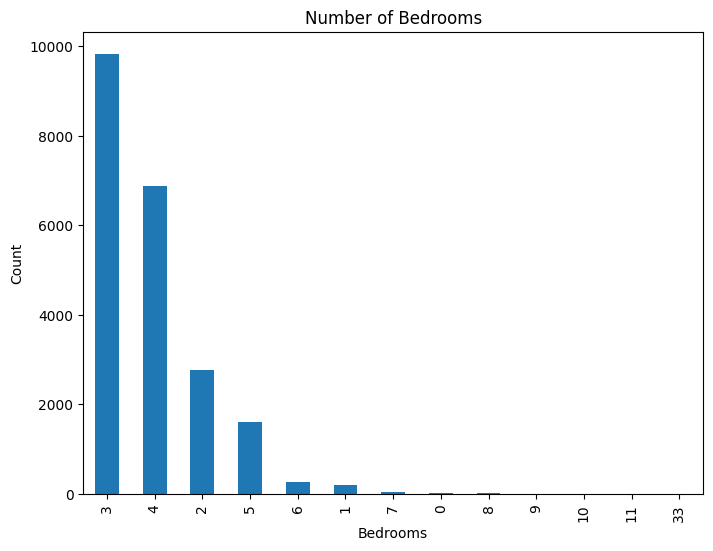

In [28]:
plt.figure(figsize=(8, 6))
data['bedrooms'].value_counts().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

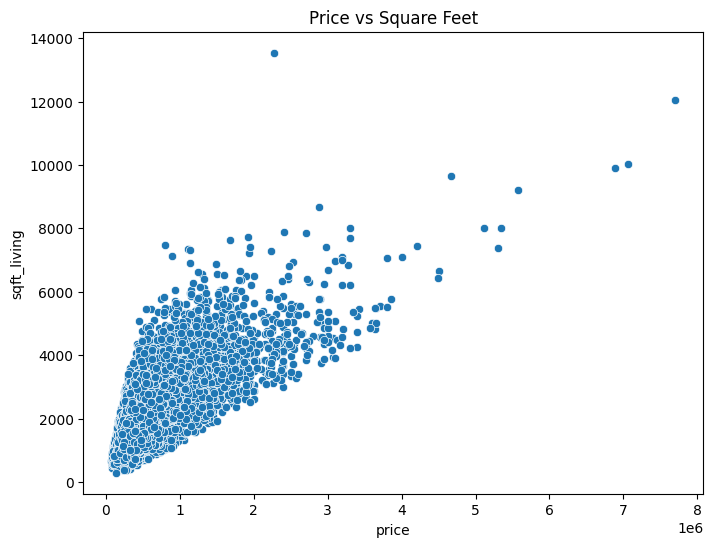

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='sqft_living', data=data)
plt.title("Price vs Square Feet")
plt.show()


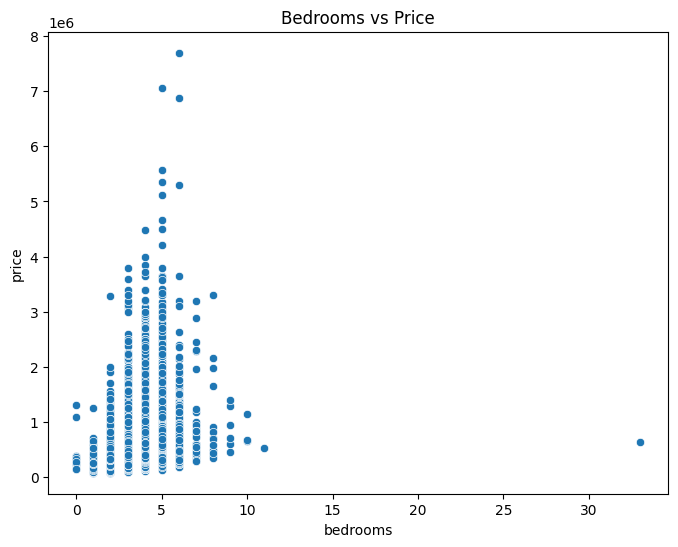

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bedrooms', y='price', data=data)
plt.title("Bedrooms vs Price")
plt.show()

# Data Preprocessing

In [31]:
data['date'] = pd.to_datetime(data['date']).dt.year
X = data.drop(['id', 'price'], axis=1)
y = data['price']

# Train-test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)



# Linear Regression Model

In [33]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_score = linear_reg.score(X_test, y_test)
print(f"Linear Regression R^2 Score: {linear_reg_score:.4f}")

Linear Regression R^2 Score: 0.8407


# Gradient Boosting Regressor


In [35]:
gb_reg = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.1, loss='squared_error')
gb_reg.fit(X_train, y_train)
gb_reg_score = gb_reg.score(X_test, y_test)
print(f"Gradient Boosting R^2 Score: {gb_reg_score:.4f}")

Gradient Boosting R^2 Score: 0.9205


# Plot Training vs Testing Error

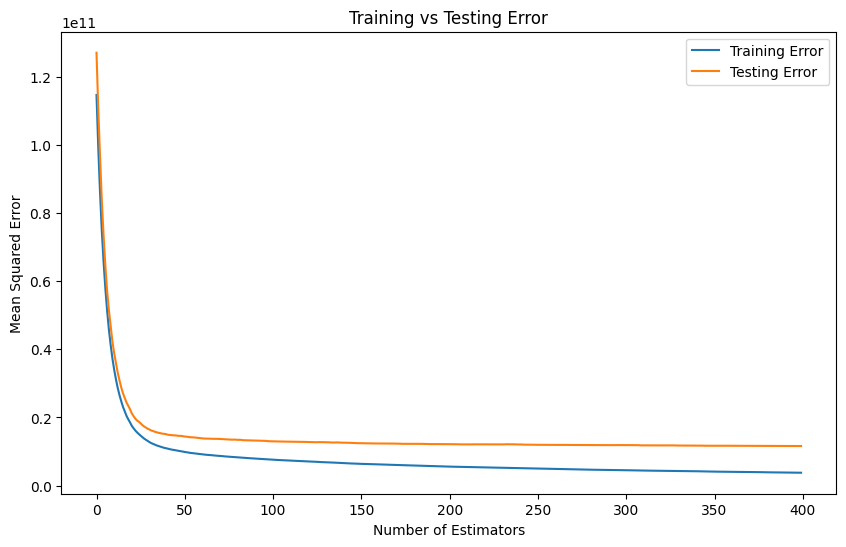

In [36]:
train_errors = []
test_errors = []
for y_pred_train, y_pred_test in zip(gb_reg.staged_predict(X_train), gb_reg.staged_predict(X_test)):
    train_errors.append(mean_squared_error(y_train, y_pred_train))
    test_errors.append(mean_squared_error(y_test, y_pred_test))

plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Training Error')
plt.plot(test_errors, label='Testing Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Testing Error')
plt.legend()
plt.show()


# Principal Component Analysis (PCA)

Explained Variance Ratio: [0.07274324 0.0334816  0.02477278 0.02076293 0.01892325]


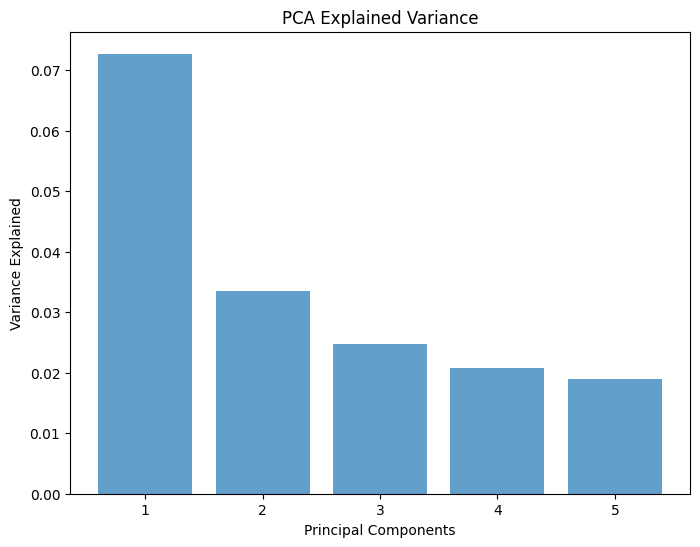

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.show()